# Plot inclination vs time

In [0]:
# Import necessary packages & set-up plotting aesthetics

import numpy as np 
import pylab
import pandas as pd
import lal
import importlib

import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib.lines import Line2D

import seaborn as sns
cp = sns.color_palette('colorblind')
cp2 = sns.color_palette('pastel')

from helper_functions import *

import sys
sys.path.append('../utils')
import reconstructwf as rwf

style.use('plotting.mplstyle')

data_dir = '../data/' 

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


### Load in data: strain timeseries

Load in time-domain data from the detectors

In [1]:
data_dict =  np.load(data_dir+'LVC_strain_data.npy', allow_pickle=True).item()
wh_data_dict =  np.load(data_dir+'LVC_strain_data_whitened.npy', allow_pickle=True).item()
time_dict_data =  np.load(data_dir+'LVC_time_data.npy', allow_pickle=True).item()

Load in reconstructions and angles from before/after each cutoff time

In [2]:
# waveform reconstructions
reconstruction_dict_all = np.load(data_dir+"waveform_reconstructions_all_detectors.npy", allow_pickle=True).item()
reconstruction_dict = {k:reconstruction_dict_all[k]['L1'] for k in reconstruction_dict_all.keys()}

# angles vs time
angles_vs_time_dict =  np.load(data_dir+'angles_vs_time_dict.npy', allow_pickle=True).item()

### Plot 

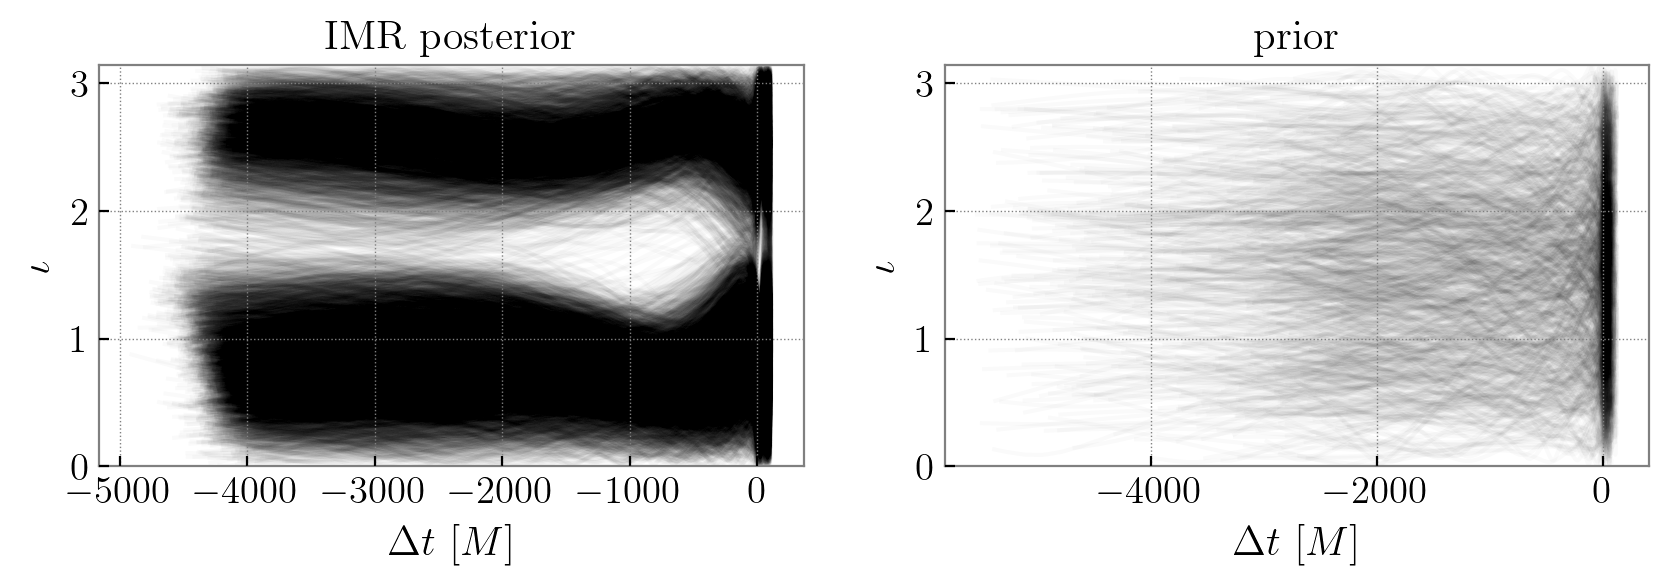

In [3]:
# Make figure
times_to_plot = ['full', 'prior']
n_traces_to_plot = 500
colors = ['k']

fig, axes = plt.subplots(1, 2, figsize=(10, 25/8/1.2))

handles = []

for i,run in enumerate(times_to_plot): 
    
    angle = 'incl'
    
    # plot all traces
    angle_vs_time = np.asarray(angles_vs_time_dict[run][angle])
    time = np.asarray(angles_vs_time_dict[run]['time_M'])
    axes[i].plot(time.T, angle_vs_time.T, color='k', alpha=0.02, zorder=0)

for ax in axes: 

    #ax.set_xlim(-100,0)
    ax.set_xlabel(r'$\Delta t~[M]$', fontsize=15)
    
    ax.set_ylim(0, np.pi)
    
axes[0].set_ylabel(r'$\iota$', fontsize=15)
axes[1].set_ylabel(r'$\iota$', fontsize=15)


axes[0].set_title('IMR posterior', fontsize=15)
axes[1].set_title('prior', fontsize=15)

plt.subplots_adjust(wspace=0.2)
plt.show()

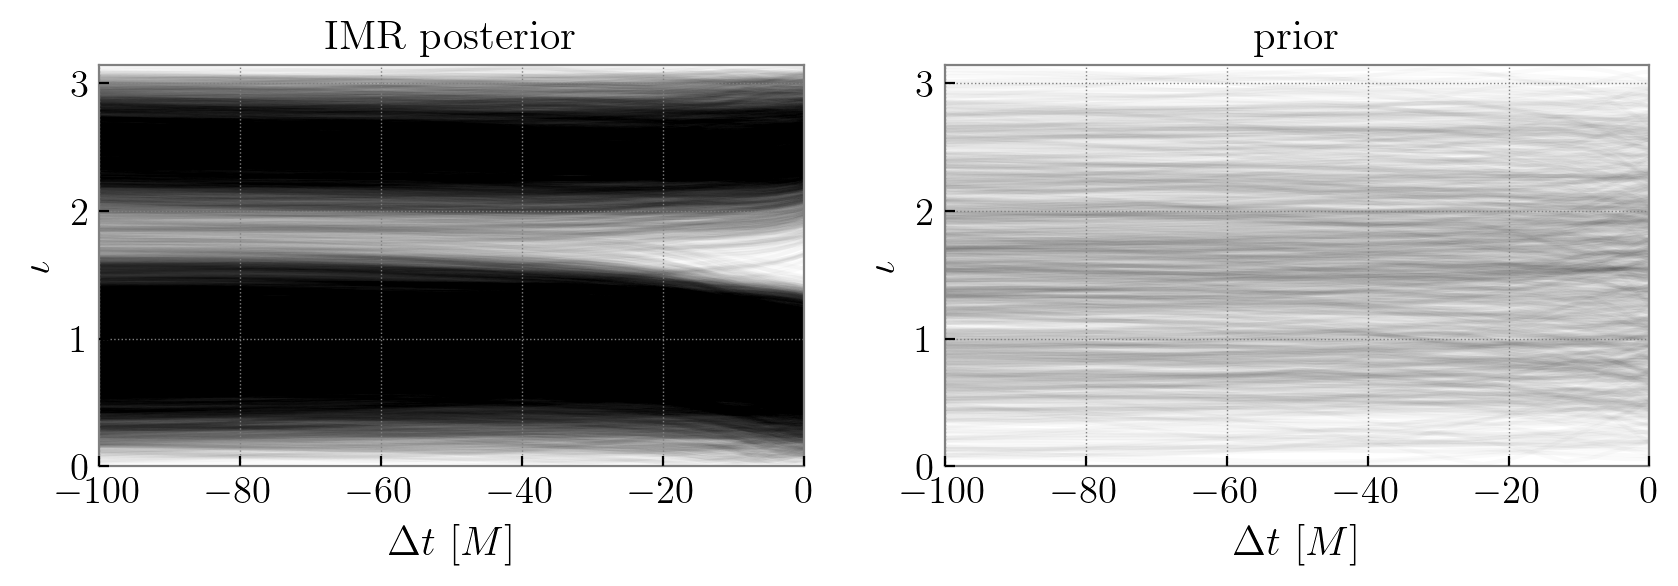

In [4]:
# Make figure
times_to_plot = ['full', 'prior']
n_traces_to_plot = 500
colors = ['k']

fig, axes = plt.subplots(1, 2, figsize=(10, 25/8/1.2))

handles = []

for i,run in enumerate(times_to_plot): 
    
    angle = 'incl'
    
    # plot all traces
    angle_vs_time = np.asarray(angles_vs_time_dict[run][angle])
    time = np.asarray(angles_vs_time_dict[run]['time_M'])
    axes[i].plot(time.T, angle_vs_time.T, color='k', alpha=0.02, zorder=0)

for ax in axes: 

    ax.set_xlim(-100,0)
    ax.set_xlabel(r'$\Delta t~[M]$', fontsize=15)
    
    ax.set_ylim(0, np.pi)
    
axes[0].set_ylabel(r'$\iota$', fontsize=15)
axes[1].set_ylabel(r'$\iota$', fontsize=15)


axes[0].set_title('IMR posterior', fontsize=15)
axes[1].set_title('prior', fontsize=15)

plt.subplots_adjust(wspace=0.2)
plt.show()

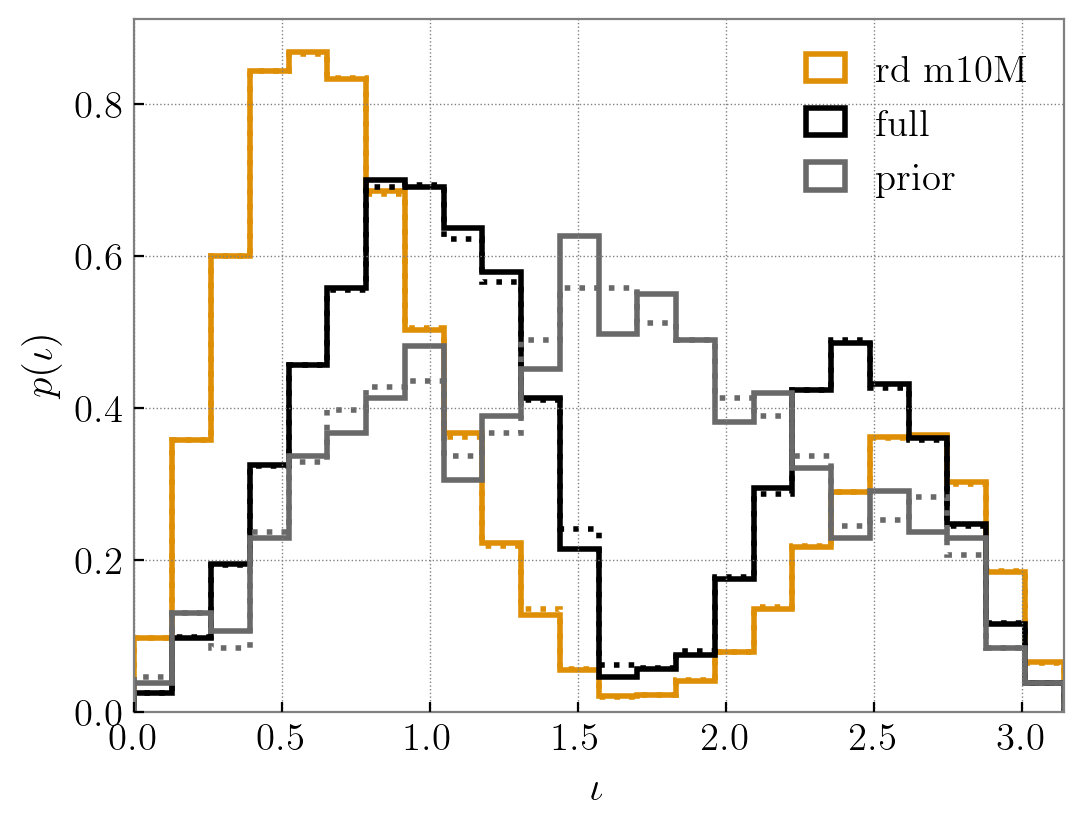

In [5]:
times_to_plot = ['rd m10M', 'full', 'prior']

colors_dict = {
    'rd m10M':cp[1],
    'full':'k', 
    'prior':'dimgray'
}

plt.figure()

for i,run in enumerate(times_to_plot): 
    
    angle = 'incl'
    
    # plot all traces
    angle_vs_time = np.array(angles_vs_time_dict[run][angle])
    time = np.array(angles_vs_time_dict[run]['time_M'])
    TCUT = -28
    
    # for mass rescaling
    M_arr =  reconstruction_dict[run]['params']['mtotal']
    Mf = 258.3
    
    angle_at_tcut = [] 
    angle_at_cut_2 = []
    for a,t,M in zip(angle_vs_time, time, M_arr):
        
        idx = np.argmin(np.abs(t - TCUT))
        angle_at_tcut.append(a[idx])
        idx2 = np.argmin(np.abs(t * (M / Mf) - TCUT))
        angle_at_cut_2.append(a[idx2])
    
    bounds = [0, np.pi]
    
    plt.hist(angle_at_tcut, density=True, histtype='step', bins=np.linspace(*bounds, 25), 
             lw=2, color=colors_dict[run], label=run)
    
    plt.hist(angle_at_cut_2, density=True, histtype='step', bins=np.linspace(*bounds, 25), 
             lw=2, color=colors_dict[run], ls=':')

plt.xlabel(r'$\iota$', fontsize=15)
plt.ylabel(r'$p(\iota)$', fontsize=15)
plt.xlim(*bounds)
plt.legend()
plt.show()

### Fig for Ilya

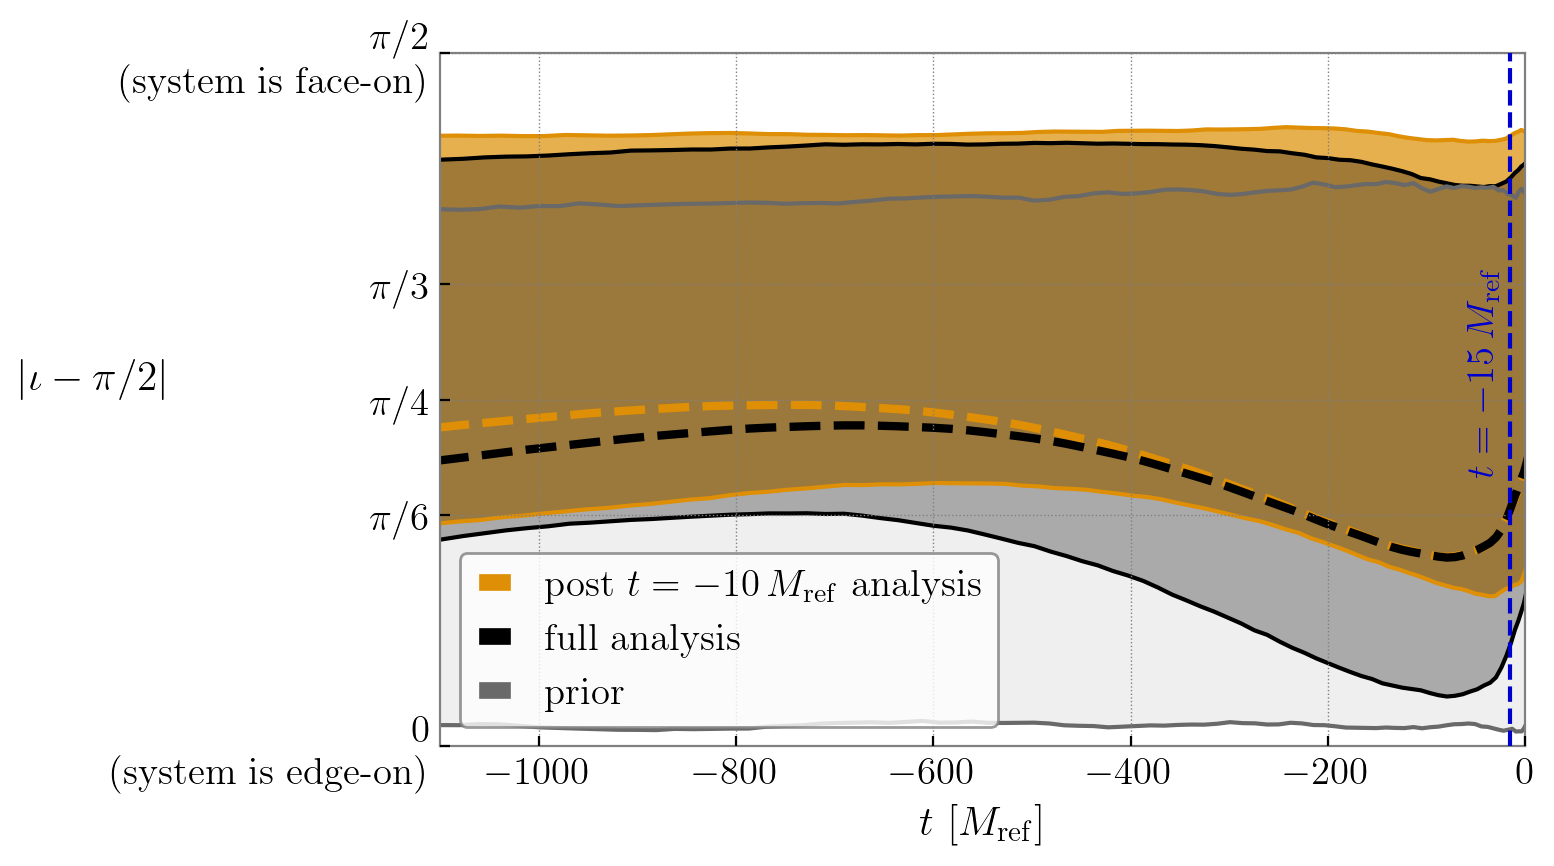

In [10]:
times_to_plot = ['rd m10M', 'full', 'prior']

colors_dict = {
    'rd m10M':cp[1],
    'full':'k', 
    'prior':'dimgray'
}

alpha_dict = {
    'rd m10M':0.7,
    'full':0.3, 
    'prior':0.1
}

plt.figure(figsize=(7,4.5))

for i,run in enumerate(times_to_plot): 
    
    lnP = reconstruction_dict[run]['params']['ln_posterior']
    imax = np.argmax(lnP)
        
    angle_vs_time = np.abs(np.asarray(angles_vs_time_dict[run]['incl']) - np.pi/2)
    time = np.asarray(angles_vs_time_dict[run]['time_M'])[imax] ##wrong
    
    # Quantiles
    quants = np.quantile(angle_vs_time, [0.05, 0.95], axis=0)
    plt.plot(time, np.transpose(quants), color=colors_dict[run],  alpha=1) 
    plt.fill_between(time, quants[0], y2=quants[1], color=colors_dict[run], alpha=alpha_dict[run])
    
    # MAP 
    if run!='prior':
        plt.plot(time, angle_vs_time[imax], color=colors_dict[run],  alpha=1, ls='--', lw=3) 
        
plt.ylabel(r'$|\iota - \pi/2|$', fontsize=15, rotation=0)
plt.xlabel(r'$t~[M_\mathrm{ref}]$', fontsize=15)
plt.xlim(-1100,0)
plt.ylim(0, np.pi/2)

plt.yticks([0, np.pi/6, np.pi/4, np.pi/3, np.pi/2], 
    labels=['0\n(system is edge-on)', r'$\pi/6$', r'$\pi/4$', r'$\pi/3$', '$\pi/2$\n(system is face-on)'])

handles = [
    Line2D([], [], color=colors_dict['rd m10M'], label=r'post $t=-10\,M_\mathrm{ref}$ analysis'),
    Line2D([], [], color=colors_dict['full'], label='full analysis'),
    Line2D([], [], color=colors_dict['prior'], label='prior')
]
plt.legend(handles=handles, loc='lower left', frameon=True, fancybox=True)

c = 'mediumblue'
T_CUT = -15
plt.axvline(T_CUT, color=c, ls='--', zorder=5)
plt.text(T_CUT-45, np.pi/6+0.1, f'$t={{{T_CUT}}}\,M_\mathrm{{ref}}$', color=c, fontsize=14, zorder=5, rotation=90)

plt.savefig('incl_vs_time.png', bbox_inches='tight', dpi=300)

plt.show()